# Speech Recognition Project
We want to make a monophone recognition system.
Train and test data are available in the `database` folder.

## Preprocessing and Feature Extraction
Frist, we're going to get sound files as input.
To do that, we need to find the name of all train files then store samples for each one in a Python dictionary.

In [1]:
import os
import scipy.io.wavfile
import numpy as np

TRAIN_DATA_DIR = os.path.join(os.curdir, 'database', 'train')
SPEAKER_LIST = [d for d in os.listdir(TRAIN_DATA_DIR) if os.path.isdir(os.path.join(TRAIN_DATA_DIR, d))]

# store filenames in this list
train_filenames = []
for s in SPEAKER_LIST:
    train_filenames.extend([os.path.join(s, f) for f in os.listdir(os.path.join(TRAIN_DATA_DIR, s))
                            if f.endswith('.wav')])
train_filenames.sort()

Now we're going to define a function that returns frames for a given signal.

In [2]:
def get_frames(array, step, size):
    max_start = int((len(array) - size) / step) + 1
    window = [array[i * step:i * step + size] for i in range(max_start)]
    last = array[max_start * step:]
    window.append(np.pad(last, (0, size - len(last)), 'constant'))
    window.append(np.zeros(size)) # append a zero frame to all files
    
    return window

Read each file and store the frames in a list.

In [3]:
STEP_SECONDS = 0.01
WINDOW_SIZE_SECONDS = 0.025

samples = dict.fromkeys(train_filenames)
for filename in samples:
    # read file
    [fs, y] = scipy.io.wavfile.read(os.path.join(TRAIN_DATA_DIR, filename))
    # divide the signal to frames and apply the hamming window function on them
    samples[filename] = [f * np.hamming(len(f))
                         for f in get_frames(y, int(fs * STEP_SECONDS), int(fs * WINDOW_SIZE_SECONDS))]

Here we just plot one of the frames to show the imported signal (just as an example).

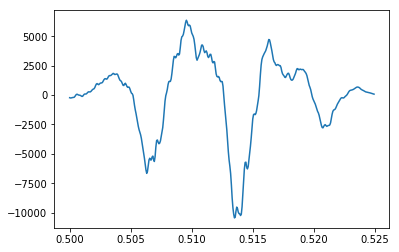

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

frame_number = 50
plt.plot(np.linspace(0, WINDOW_SIZE_SECONDS,
                     int(16000 * WINDOW_SIZE_SECONDS),
                     endpoint=False) + frame_number * STEP_SECONDS,
        list(samples.values())[0][frame_number])
plt.show()

### Mel Frequency Cepstral Coefficients (MFCCs)

First, we define some functions then we write the code which calls these functions on each frame.

#### Computing the Mel Filterbank
To compute the filter bank:
 1. Pick some low and high frequencies (we choose 300Hz and 8KHz).
 2. Calculate Mel points (we choose to calculate 26 of them).
 3. Convert Mels back to Hertz.
 4. Round the resulting points (called Mel pints).
 5. Create the filterbanks.The first filterbank will start at the first point, reach its peak at the second point, then return to zero at the 3rd point. The second filterbank will start at the 2nd point, reach its max at the 3rd, then be zero at the 4th etc. A formula for calculating these is as follows:
 
 $$
     H_m(k) = 
    \begin{cases} 
        0                                & k < f(m-1) \\
        \frac{k - f(m-1)}{f(m) - f(m-1)} & f(m-1) \leq k \leq f(m) \\
        \frac{f(m+1) - k}{f(m+1) - f(m)} & f(m) \leq k \leq f(m+1) \\
        0                                & k > f(m+1)
    \end{cases}
 $$

 where $ M $ is the number of filters we want, and $ f $ is the list of $ M + 2 $ Mel-spaced frequencies. 

Now we define some helper functions to convert Mels to Hertz and vice versa.

To convert from frequency to Mel:

$$ M(f) = 1125\ln\left(1+\frac{f}{700}\right) $$

And to convert from Mel to frequency:

$$ M^{-1}(m) = 700 \times \left(e^{\frac{m}{1125}} - 1\right) $$

In [5]:
hz2mel = lambda hz: 1125 * np.log(1 + (hz / 700.)) # supports numpy arrays.
mel2hz = lambda mel: 700 * (np.e ** (mel / 1125.) - 1) # supports numpy arrays.

Now we define the function that calculates Mel filterbanks.

This function receives the following parameters:

| Parameter        | Description                                                                                  |
|------------------|----------------------------------------------------------------------------------------------|
| `n`              | number of filterbanks returned.                                                              |
| `nfft`           | length of fft output.                                                                        |
| `samplerate`     | sampling rate of the audio files.                                                            |
| `low_frequency`  | starting frequency for filterbanks.                                                          |
| `high_frequency` | high frequency for filter banks (this can't be more than $ \frac{\mathtt{samplerate}}{2} $). |

In [6]:
def get_mel_filterbanks(n=26, nfft=512, samplerate=16000, low_frequency=300, high_frequency=8000): # step 1
    mel = np.linspace(hz2mel(low_frequency), hz2mel(high_frequency), n + 2) # step 2
    hertz = mel2hz(mel) # step 3
    fftbin = np.floor((nfft + 1) * hertz / samplerate).astype(np.int64) # step 4

    fbank = np.zeros([n, (nfft // 2) + 1]) # step 5
    for j in range(n):
        for i in range(fftbin[j], fftbin[j+1]):
            fbank[j, i] = (i - fftbin[j]) / (fftbin[j + 1] - fftbin[j])
        for i in range(fftbin[j + 1], fftbin[j + 2]):
            fbank[j, i] = (fftbin[j + 2] - i) / (fftbin[j + 2] - fftbin[j + 1])
    
    return fbank

So once again we just plot these banks for testing.

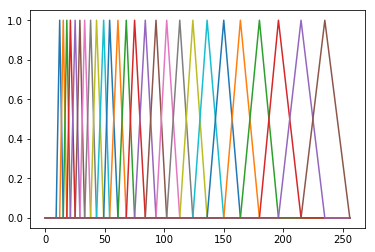

In [7]:
fbank = get_mel_filterbanks()

for filt in fbank:
    plt.plot(filt)
plt.show()

Now, we take a glimpse at the steps to compute MFCCs:


1. Frame the signal into short frames (already done).
2. For each frame calculate the periodogram estimate of the power spectrum.
   
   Suppose that we show our original signal of frame $ i $ with notation $ s_i(n) $ (n being the number of sample).
   When we calculate the complex DFT we get $ S_i(k) $.
   
   $$ S_i(k) = \sum_{n=1}^{N} s_i(n)h(n)e^{\frac{-j2\pi kn}{N}} $$
   
   where $ h(n) $ is an $ N $ sample long analysis window (e.g. hamming window), and $ K $ is the length of the DFT.
   The periodogram-based power spectral estimate for the speech frame $ s_i(n) $ is given by:
   
   $$ P_i(k) = \frac{1}{N}\left\lvert S_i(k) \right\rvert^2 $$
   
   This is called the Periodogram estimate of the power spectrum.
   We take the absolute value of the complex fourier transform, and square the result.
   We would generally perform a 512 point FFT and keep only the first 257 coefficents.
3. Apply the Mel filterbank to the power spectra, sum the energy in each filter.
4. Take the logarithm of all filterbank energies.
5. Take the DCT of the log filterbank energies.
6. Keep DCT coefficients 2-13, discard the rest.
7. Calculate frame energy.
   
   To do that, simply sum the power spectrum
   (because power spectrum is actually energy of the signal in different frequencies).

To do the above tasks, we first define a function that computes MFCCs for a certain frame, then call this function on each of the frames later.

This function receives the following parameters:

| Parameter | Description                                         |
|-----------|-----------------------------------------------------|
| `signal`  | a single frame of signal which contians 400 samples |

In [8]:
from scipy.fftpack import dct

def mfcc(signal, nfft=512):
    # already multiplied signal by hamming window so all we need to to do is to call fft
    magspec = np.absolute(np.fft.rfft(signal, nfft))
    powspec = (1. / len(signal)) * np.square(magspec) # step 2
    
    fbank = get_mel_filterbanks()
    
    ft = np.dot(powspec, fbank.T) # step 3
    ft = np.where(ft == 0, np.finfo(float).eps, ft) # if feat is zero, we get problems with log
    
    ft = np.log(ft) # step 4
    
    ft = dct(ft, norm='ortho')[:,:12] # steps 5 and 6
    
    energy = np.sum(powspec, 1) # step 7
    energy = np.where(energy == 0,np.finfo(float).eps,energy) # if energy is zero, we get problems with log
    
    ft = [np.append(ft[i], energy[i]) for i in range(len(energy))]
    
    return ft

### Normalize Features
Next thing, we should normalize feature parameters for each speaker. So we first define a function which gives all features for a specific speaker. Then we define two functions which give mean and variance of features for a speaker.

In [9]:
def get_features_for_speaker(features, speaker):
    if speaker not in SPEAKER_LIST:
        raise ValueError("Invalid sim type. Expected one of: %s" % SPEAKER_LIST)
    
    ft = []
    for key in features:
        if key.startswith(speaker):
            ft.extend(features[key])
    
    return ft

mean_for_speaker = lambda f, s: np.mean(get_features_for_speaker(f, s), axis=0)
var_for_speaker = lambda f, s: np.var(get_features_for_speaker(f, s), axis=0)

Now that we're finished, we can easily extract features of all the train files and store it in a global variable. Then we use our recently defined functions to normalize these values.

In [10]:
features = {key: mfcc(samples[key]) for key in samples}

mean = {sp: mean_for_speaker(features, sp) for sp in SPEAKER_LIST}
var = {sp: var_for_speaker(features, sp) for sp in SPEAKER_LIST}

for key in features:
    speaker = os.path.split(key)[0]
    features[key] = [(f - mean[speaker]) / var[speaker] for f in features[key]]